In [ ]:
import pandas as pd
import os
import numpy as np

df_netflix = pd.read_csv("../data/netflix_titles.csv");
df_netflix.head()

In [ ]:
#Data cleaning and choosing relevant features

#We keep the relevant features for recomendation and drop NaN values
df_netflix.dropna()
df_netflix.head()
df_netflix_trimmed = df_netflix[['description', 'listed_in']]


In [ ]:
#Create a new feature, containing all the text for every line

def create_soup(line):
    return pd.Series(line['description'] + line['listed_in']) #Puede que title influya demasiado

df_soup = df_netflix_trimmed.apply(create_soup, axis=1) #Aplica a cada fila
df_soup.columns = ['soup']
df_soup['soup'] = df_soup['soup'].str.lower()
df_soup.head()

,soup
0,"as her father nears the end of his life, filmm..."
1,"after crossing paths at a party, a cape town t..."
2,to protect his family from a powerful drug lor...
3,"feuds, flirtations and toilet talk go down amo..."
4,in a city of coaching centers known to train i...


In [ ]:
#Now I have to vectorize the text using Tfid from scikit learn
#Tfid will create a matrix where weights are assigned to words, depending on the importance on the movie
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer(stop_words='english', token_pattern=r'(?u)\b[a-zA-Z]{2,}\b') #To exclude numbers
data_mat = vectorizer.fit_transform(df_soup['soup']) #Vectorize all data
print(data_mat.shape)

(8807, 18477)


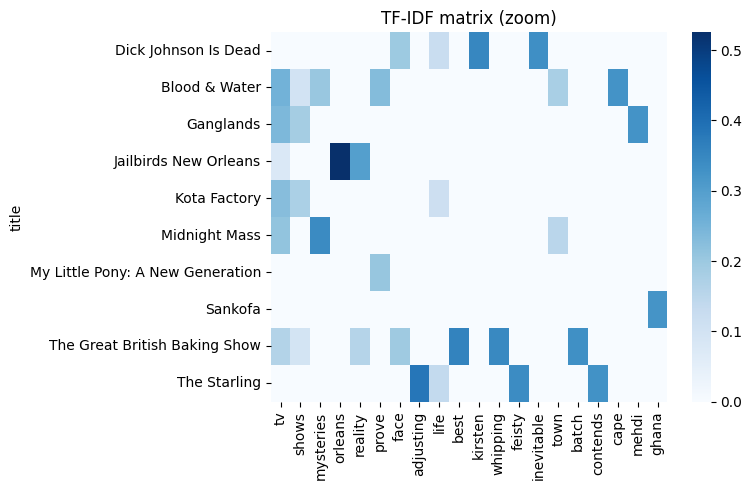

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

sample_df = pd.DataFrame(
    data_mat[:10].toarray(),
    columns = vectorizer.get_feature_names_out(),
    index = df_netflix['title'].iloc[:10]
)

top_words = (
    sample_df.mean()
    .sort_values(ascending=False)
    .head(20)
    .index
)

#The heatmap shows the most 'unique' words of each document
plt.figure();
sns.heatmap(sample_df[top_words], annot=False, cmap='Blues');
plt.title('TF-IDF matrix (zoom)');
plt.show()


In [ ]:
#We compare similar movies using cosine similarity

from sklearn.metrics.pairwise import cosine_similarity

cos_res = cosine_similarity(data_mat, data_mat)

In [ ]:
#Recomendation engine
#Input:movie name
#Output: Similar movies

#Movies must be mapped to indexes

df_indexes = pd.Series(df_netflix.index, index=df_netflix['title'])

def search_engine():
    movie = input("Choose a movie and get similar ones: ")
    idx = df_indexes[movie]
    sim_scores = sorted(list(enumerate(cos_res[idx])), key=lambda x: x[1], reverse=True)
    top_matches = sim_scores[1:6]
    
    indices = [i[0] for i in top_matches]
    scores = [i[1] for i in top_matches]
    
    res_df = pd.DataFrame({
        f'Similar to {movie}': df_netflix['title'].iloc[indices].values,
        'Similitud': scores
    })
    
    return res_df.style.background_gradient(cmap='Reds')\
                       .format({'Similitud': "{:.2%}"})\
                       .hide(axis='index')

In [ ]:
#Proof, typing: "Narcos"

search_engine()

Similar to Narcos,Similitud
Miss Dynamite,31.82%
El Chapo,30.65%
Narcos: Mexico,30.24%
El Cartel 2,28.15%
Ganglands,25.77%


In [ ]:
#Proof, typing: "Green Lantern"

search_engine()

Similar to Green Lantern,Similitud
Spectral,23.22%
The Umbrella Academy,18.66%
Avengers: Infinity War,17.79%
Halo: The Fall of Reach,17.23%
Occupation,17.00%


In [ ]:
#Proof, typing: "Jaws"

search_engine()

Similar to Jaws,Similitud
Jaws: The Revenge,46.52%
Jaws 2,45.17%
Jaws 3,23.67%
Maya Memsaab,16.11%
In The Deep,15.82%
